In [13]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16,VGG19,ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf

print("Tensorlfow Version: ", tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed


Tensorlfow Version:  2.15.0


In [14]:
import os

cwd = os.getcwd()
base_dir = os.path.abspath(os.path.join(cwd, '..'))
data_dir = os.path.join(base_dir, 'DATA', 'animal_expression_detection', 'Master Folder')
trainpath = os.path.join(data_dir, 'train')
testpath = os.path.join(data_dir, 'test')
validpath = os.path.join(data_dir, 'valid')

print(f"Train path: {trainpath}")
print(f"Test path: {testpath}")
print(f"Valid path: {validpath}")


Train path: C:\Users\Harsh\Downloads\data_science01\dl_projects\task 2\DATA\animal_expression_detection\Master Folder\train
Test path: C:\Users\Harsh\Downloads\data_science01\dl_projects\task 2\DATA\animal_expression_detection\Master Folder\test
Valid path: C:\Users\Harsh\Downloads\data_science01\dl_projects\task 2\DATA\animal_expression_detection\Master Folder\valid


In [15]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(trainpath)))
random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (48, 48))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "happy":
            label = 0
        elif label == "Sad":
            label = 1
        elif label == "Angry":
            label = 2
        elif label == "Other":
            label = 3

        # print("pr: ", label)	

        labels.append(label)
        
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [17]:
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

In [18]:
labels

array([0, 1, 0, 0, 2, 3, 2, 0, 3, 1, 2, 0, 3, 1, 1, 1, 0, 2, 1, 3, 3, 0,
       3, 3, 1, 3, 1, 1, 3, 0, 1, 0, 0, 3, 0, 3, 1, 1, 2, 3, 2, 3, 0, 2,
       3, 0, 2, 2, 1, 2, 3, 0, 2, 2, 3, 1, 1, 0, 2, 1, 1, 3, 1, 3, 3, 0,
       3, 2, 2, 2, 2, 3, 3, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 3,
       1, 2, 1, 2, 3, 1, 2, 0, 3, 1, 3, 0, 1, 3, 0, 0, 1, 0, 0, 1, 3, 1,
       0, 2, 3, 2, 3, 0, 3, 1, 2, 2, 1, 3, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0,
       0, 3, 1, 0, 2, 2, 3, 0, 0, 0, 0, 3, 1, 3, 3, 3, 3, 1, 1, 0, 3, 1,
       1, 3, 2, 3, 1, 1, 1, 2, 1, 3, 0, 1, 3, 0, 3, 2, 0, 3, 3, 3, 1, 0,
       1, 2, 1, 0, 3, 3, 2, 2, 3, 3, 0, 0, 0, 3, 2, 2, 3, 3, 3, 1, 1, 2,
       2, 3, 0, 2, 2, 3, 0, 2, 0, 2, 0, 3, 0, 1, 0, 2, 1, 0, 1, 1, 0, 3,
       2, 3, 2, 2, 0, 2, 1, 2, 0, 1, 2, 0, 1, 3, 1, 2, 0, 1, 1, 2, 1, 0,
       1, 1, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 2, 1, 3, 1, 0, 2, 0, 1, 0, 3,
       3, 0, 2, 1, 0, 1, 3, 2, 2, 3, 2, 2, 1, 2, 3, 3, 3, 1, 3, 3, 2, 0,
       3, 3, 0, 0, 1, 2, 1, 1, 3, 0, 2, 2, 3, 1, 2,

In [19]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [20]:
testX = np.array(testX)
print(testX.shape)

(250, 48, 48, 3)


In [21]:
trainX = np.array(trainX)
print(trainX.shape)

(750, 48, 48, 3)


In [10]:
trainY = to_categorical(trainY, num_classes=4)
testY = to_categorical(testY, num_classes=4)

In [11]:
def plot_acc(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("acc_output.png")

def plot_loss(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig("loss_output.png")

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU


from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf

print("Tensorlfow Version: ", tf.__version__)
warnings.filterwarnings("ignore")
SEED = 43   # set random seed

Tensorlfow Version:  2.15.0


In [13]:
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)  # (h, h, channel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => LeakyReLU => POOL layers
        model.add(Conv2D(20, (4,4), padding="same", input_shape=inputShape))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => LeakyReLU => POOL layers
        model.add(Conv2D(50, (4,4), padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # third set of CONV => LeakyReLU => POOL layers
        model.add(Conv2D(100, (4,4), padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => LeakyReLU layers
        model.add(Flatten())
        model.add(Dense(200))
        model.add(LeakyReLU(alpha=0.1))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [14]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=48, height=48, depth=3, classes=4)
opt = Adam(learning_rate=1e-3)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")


[INFO] compiling model...


[INFO] model complied...


In [15]:
# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=64),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // 64,
              epochs=100, 
              verbose=1)

[INFO] training network...
Epoch 1/100


11/11 [==============================] - 3s 113ms/step - loss: 1.4108 - accuracy: 0.2493 - val_loss: 1.3841 - val_accuracy: 0.2680
Epoch 2/100
11/11 [==============================] - 1s 75ms/step - loss: 1.3794 - accuracy: 0.2872 - val_loss: 1.3875 - val_accuracy: 0.2320
Epoch 3/100
11/11 [==============================] - 1s 65ms/step - loss: 1.3725 - accuracy: 0.2857 - val_loss: 1.3746 - val_accuracy: 0.2880
Epoch 4/100
11/11 [==============================] - 1s 78ms/step - loss: 1.3593 - accuracy: 0.3324 - val_loss: 1.3705 - val_accuracy: 0.2840
Epoch 5/100
11/11 [==============================] - 1s 80ms/step - loss: 1.3453 - accuracy: 0.3236 - val_loss: 1.3609 - val_accuracy: 0.2800
Epoch 6/100
11/11 [==============================] - 1s 79ms/step - loss: 1.3185 - accuracy: 0.3630 - val_loss: 1.3374 - val_accuracy: 0.3240
Epoch 7/100
11/11 [==============================] - 1s 72ms/step - loss: 1.3134 - accuracy: 0.3469 - val_loss: 1.3277

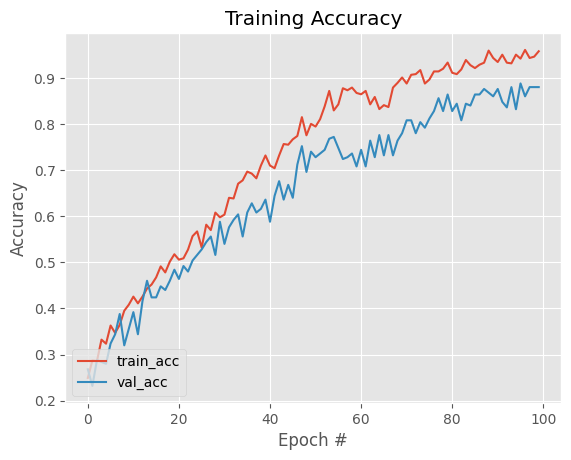

In [22]:
plot_acc(H,100)

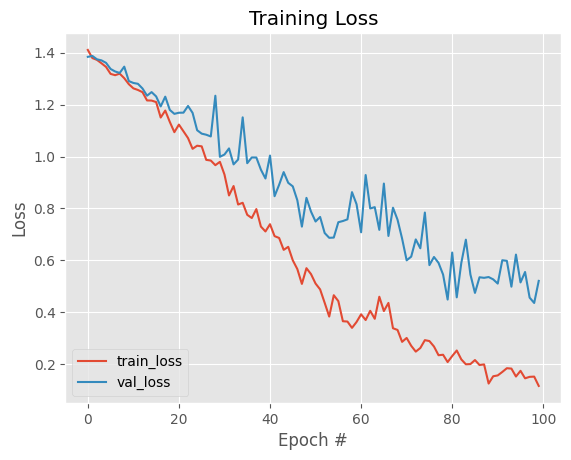

In [23]:
plot_loss(H,100)